In [3]:
#  imports & display options
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

sns.set(style="whitegrid", context="notebook", rc={"figure.figsize": (10,6)})
pd.set_option('display.max_columns', None)

DATA_DIR = Path('../data')  
COUNTRIES = ['benin-malanville','sierraleone-bumbuna','togo-dapaong_qc']   # use the file roots (without _clean.csv)


In [4]:
#  load cleaned datasets into a dict of dataframes
dfs = {}
for c in COUNTRIES:
    p = DATA_DIR / f"{c}_clean.csv"
    dfs[c] = pd.read_csv(p, parse_dates=['Timestamp'])
    dfs[c]['country'] = c  # add country label
    print(c, "rows:", len(dfs[c]))

# quick peek - concat first rows
pd.concat([dfs[c].head(2) for c in COUNTRIES]).head()


benin-malanville rows: 525600
sierraleone-bumbuna rows: 525600
togo-dapaong_qc rows: 525600


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,country
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN,benin-malanville
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN,benin-malanville
0,2021-10-30 00:01:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.1,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN,sierraleone-bumbuna
1,2021-10-30 00:02:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN,sierraleone-bumbuna
0,2021-10-25 00:01:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN,togo-dapaong_qc


In [5]:
# Combine into single DataFrame for plotting & summary
df_all = pd.concat(dfs.values(), ignore_index=True)
df_all['country'] = df_all['country'].astype(str)


In [6]:
# Summary statistics table (mean, median, std) for metrics
metrics = ['GHI','DNI','DHI']
summary = df_all.groupby('country')[metrics].agg(['mean','median','std']).T
# nicer format: flatten MultiIndex
summary.columns = [f"{col[0]}_{col[1]}" for col in summary.columns]
summary = summary.round(3)
display(summary)
# Also produce a tidy table for reporting
summary_tidy = df_all.groupby('country')[metrics].agg(['mean','median','std']).reset_index()
summary_tidy.columns = ['country'] + [f"{m}_{s}" for m in metrics for s in ['mean','median','std']]
display(summary_tidy)


b_e      s_i      t_o
GHI mean    240.559  201.958  230.555
    median    1.800    0.300    2.100
    std     331.131  298.495  322.532
DNI mean    167.188  116.376  151.258
    median   -0.100   -0.100    0.000
    std     261.711  218.653  250.957
DHI mean    115.359  113.721  116.444
    median    1.600   -0.100    2.500
    std     158.691  158.946  156.521

,country,GHI_mean,GHI_median,GHI_std,DNI_mean,DNI_median,DNI_std,DHI_mean,DHI_median,DHI_std
0,benin-malanville,240.559452,1.8,331.131327,167.187516,-0.1,261.710501,115.358961,1.6,158.691074
1,sierraleone-bumbuna,201.957515,0.3,298.495150,116.376337,-0.1,218.652659,113.720571,-0.1,158.946032
2,togo-dapaong_qc,230.555040,2.1,322.532347,151.258469,0.0,250.956962,116.444352,2.5,156.520714


C:\Users\bethy\AppData\Local\Temp\ipykernel_15424\1027711261.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='country', y=m, data=df_all, palette='Set2')


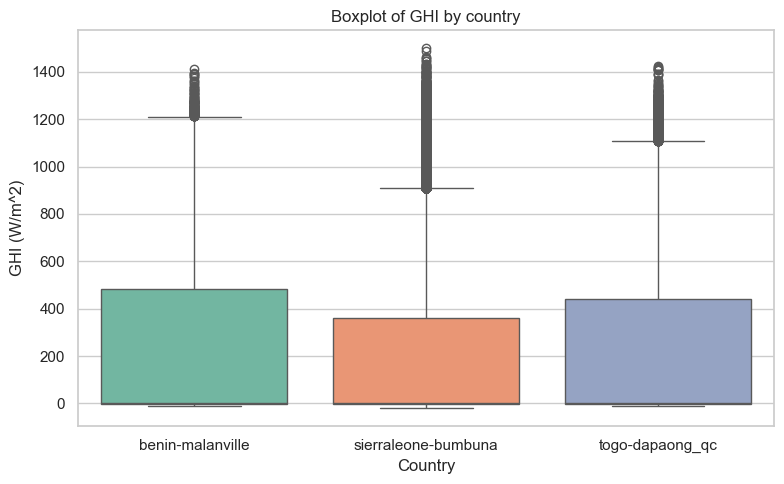

C:\Users\bethy\AppData\Local\Temp\ipykernel_15424\1027711261.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='country', y=m, data=df_all, palette='Set2')


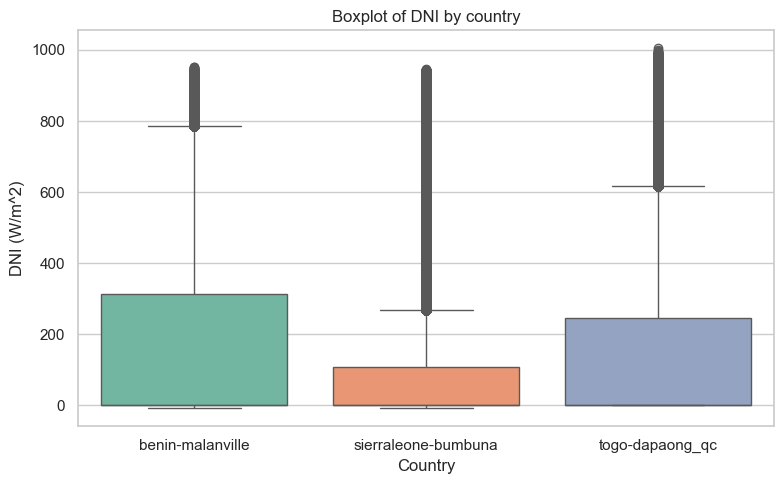

C:\Users\bethy\AppData\Local\Temp\ipykernel_15424\1027711261.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='country', y=m, data=df_all, palette='Set2')


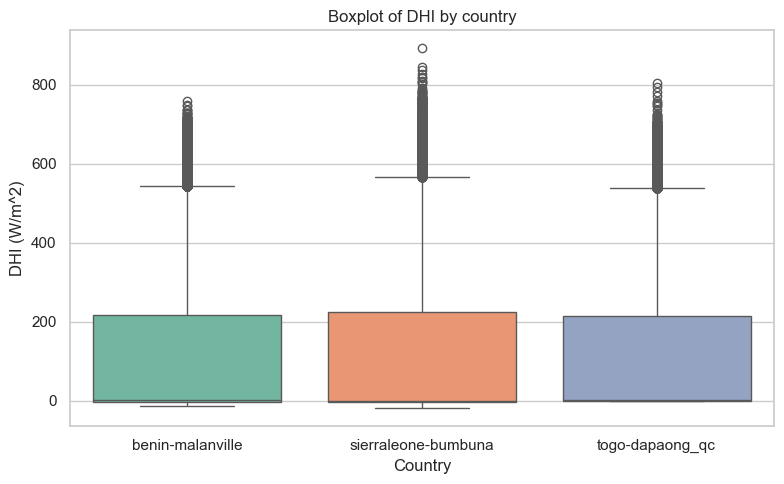

In [7]:
# boxplots, one figure per metric
for m in metrics:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='country', y=m, data=df_all, palette='Set2')
    plt.title(f"Boxplot of {m} by country")
    plt.ylabel(m + " (W/m^2)")
    plt.xlabel("Country")
    plt.tight_layout()
    plt.show()


In [ ]:
#  statistical tests
# Levene test for equal variances (important for ANOVA assumption)
for m in metrics:
    groups = [df_all.loc[df_all['country']==c, m].dropna() for c in COUNTRIES]
    le_stat, le_p = stats.levene(*groups)
    print(f"{m} — Levene stat={le_stat:.3f}, p={le_p:.3e} (H0: equal variances)")

    # choose test: if p>0.05 assume equal variances -> ANOVA, else Kruskal
    if le_p > 0.05:
        f_stat, f_p = stats.f_oneway(*groups)
        print(f"  ANOVA: F={f_stat:.3f}, p={f_p:.3e}")
    else:
        k_stat, k_p = stats.kruskal(*groups)
        print(f"  Kruskal-Wallis: H={k_stat:.3f}, p={k_p:.3e}")
    print('-'*60)


GHI — Levene stat=1877.937, p=0.000e+00 (H0: equal variances)
  Kruskal-Wallis: H=4524.883, p=0.000e+00
------------------------------------------------------------
DNI — Levene stat=5971.456, p=0.000e+00 (H0: equal variances)
  Kruskal-Wallis: H=90729.997, p=0.000e+00
------------------------------------------------------------
DHI — Levene stat=39.533, p=6.781e-18 (H0: equal variances)
  Kruskal-Wallis: H=65329.065, p=0.000e+00
------------------------------------------------------------


### Statistical Test Summary

- Levene’s test showed **unequal variances** (p < 0.05) for all three metrics (GHI, DNI, DHI), so **Kruskal–Wallis** was used instead of ANOVA.
- The Kruskal–Wallis test returned **p < 0.001** for all metrics, meaning the differences in solar radiation between Benin, Sierra Leone, and Togo are **statistically significant**.
- This confirms that Benin consistently receives higher solar irradiance, followed by Togo, with Sierra Leone showing lower overall sunlight intensity.


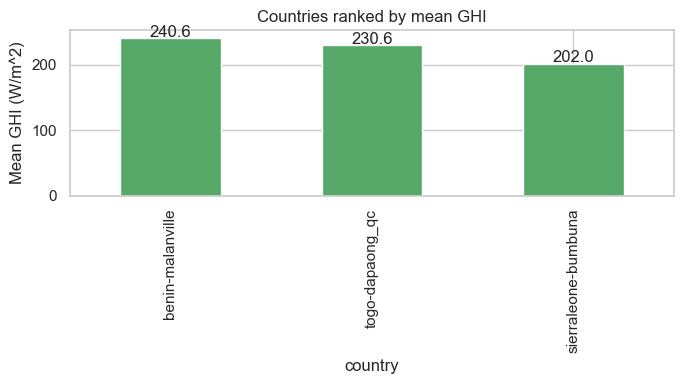

In [ ]:
#Visual summary
#  bar chart ranking by mean GHI
mean_ghi = df_all.groupby('country')['GHI'].mean().sort_values(ascending=False)
mean_ghi.plot(kind='bar', figsize=(7,4), color='C2')
plt.ylabel('Mean GHI (W/m^2)')
plt.title('Countries ranked by mean GHI')
for i, v in enumerate(mean_ghi):
    plt.text(i, v + 2, f"{v:.1f}", ha='center')
plt.tight_layout()
plt.show()


### Visual Summary: Average Solar Potential

The bar chart below ranks the three countries by their average Global Horizontal Irradiance (GHI):

- **Benin** has the highest mean GHI (~240 W/m²), indicating the strongest and most reliable solar radiation.
- **Togo** follows closely (~230 W/m²), also showing strong solar potential.
- **Sierra Leone** has a lower mean (~202 W/m²), suggesting comparatively less sunlight, possibly due to higher humidity or cloud cover.

This visual summary reinforces that **Benin offers the best solar energy opportunity**, with **Togo** also suitable and **Sierra Leone** less favorable for large-scale installations.


## 🌞 summary Cross-Country Solar Comparison

Across the three countries (Benin, Sierra Leone, and Togo), Benin shows the **highest solar potential** with a mean GHI of about **240.6 W/m²**, followed by Togo (**230.6 W/m²**) and Sierra Leone (**202.0 W/m²**).  

Boxplots of GHI, DNI, and DHI confirm this trend — Benin and Togo have **higher median irradiance** and wider distributions, while Sierra Leone’s values are consistently lower, likely due to cloud cover and humidity.  

Statistical testing (Kruskal–Wallis, p ≈ 0.000) indicates **significant differences** in solar irradiance among the countries.  

**Conclusion:**  
- ☀️ **Benin** – Highest and most consistent solar radiation → best for solar projects.  
- ⚡ **Togo** – Slightly lower but still promising.  
- 🌦️ **Sierra Leone** – Lower solar exposure; less favorable for large-scale installations.
